# C0TB1060 蒲原紳乃輔

# **課題レポート**
今回は手書き文字のデータセット(sklearn.datasetsにあるdigitsデータ)の扱い方について学習した。今回データの扱いや可視化等を学習したが、それだけでは少々物足りない。今回も次回以降の予習になると思われるが、分類器を用いた教師あり学習を実装してみる。前回の課題ではサポートベクトルマシンを用いたが、今回は単層パーセプトロンを用いた学習を行ってみる。

## 用いるアリゴリズム
単層パーセプトロン 概要：https://ja.wikipedia.org/wiki/パーセプトロン

## 実装のアイデア
1. 学習に用いる特徴量ベクトルとバイアス項を含めたベクトルと重み(任意の写像)wとの内積をzとおく
2. zに活性化関数(sigmoidやReLU関数がある)を作用させ、出力とする。
3. 多クラス分類だと、softmaxと呼ばれる関数を作用させ、確率を表す配列を返す
4. 3で得られた配列のうち最大の確率をとるインデックスをコンピューターが予想したクラスだと解釈する
5. 重みwは予測値と正解値の誤差を表すコスト関数の勾配降下により更新することができる。

<img src="https://www.imagazine.co.jp/wp-content/uploads/2018/07/110-114_16ISno12_kiso_deep-zu005.jpg" width="700" height="350">

[imagazine.co.jpより引用]

まずはデータセットの読み込みを行う

In [ ]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt 

#データセットの読み込み
digits = datasets.load_digits()
x = digits.data
y_raw = digits.target
x.shape
#出力によると、データ数1797個 特徴量の個数64個

(1797, 64)

yの出力は現在は(1,1797)の配列となっているが、多クラス分類では正解ラベルのインデックスに1が入りその他が0になる配列に変換する必要がある。この配列をone-hot arryと呼ぶ　\
eg. 正解が1の場合は[0,1,0,0,0,0,0,0,0,0]となる

In [ ]:
y = np.zeros((1797,10))

for idx in range(y_raw.shape[0]):
  label = y_raw[idx]
  y[idx][label] = 1

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

分類を行う分類器のクラスを定義する

In [ ]:
#単層ニューラルネットワークの構造としては隠れ層1つ(ニューロンの数10)→softmax→予測

class Perceptron(object):
  def __init__(self,lr,random_state):
    self.lr = lr 
    self.random_state = random_state 
    #重みの初期化(ガウス分布で初期化)
    np.random.seed(seed=32)
    self.w = np.random.normal(size=(x.shape[1], 10))
    self.b = np.zeros((x.shape[0],10))
  
  def fit(self,x,y):
    #xとwの内積とbのベクトル和
    self.a = np.dot(x,self.w) + self.b 

    # softmax unit の出力値を計算
    self.output = self.softmax(self.a)

    #コスト関数の計算
    delta = 1e-2
    #交差エントロピーを損失関数として用いる
    self.loss = -np.sum(y*np.log(self.output + delta))/x.shape[0]
    #勾配降下による重みの更新
    grad = np.dot(x.T,y - self.output)/x.shape[0] 
    self.w += self.lr * grad 
  
  def loss_func(self):
    return self.loss

  def softmax(self,x):
    #softmax関数を作用させる softmax = exp(a_i)/sum(exp(a_i))
    self.output = np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))
    return self.output
  
  def predict(self,x):
    #確率を表す配列の中で一番値の高いもののインデックス番号を取得する
    self.y_pred = np.argmax(self.output,axis=1)
    return self.y_pred 

モデルを構築したところで、インスタンスを生成して学習を行う。繰り返し回数は400回とする。損失関数の挙動を把握するためにEPOCH毎に損失関数の値を配列に格納する

In [ ]:
#学習を行う
#繰り返し回数は400回とする
EPOCH = 400
#インスタンスの定義
ppn = Perceptron(lr=0.01,random_state=1)

losses = []
for epoch in range(EPOCH):
  ppn.fit(x,y)
  loss = ppn.loss_func()
  losses.append(loss)

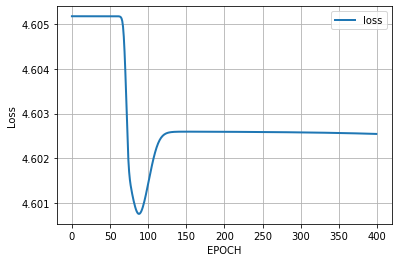

In [ ]:
plt.plot(losses,linewidth=2,label="loss")
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

ppnのpredict関数で最終的に機械が文字を何と認識したのか確かめる。そして、データ数1797個のうちどのくらい正解したのか表す正答率を計算してみる。

In [ ]:
y_pred = ppn.predict(x)
y_pred

array([0, 1, 1, ..., 1, 9, 8])

In [ ]:
corrects = 0 
y_pred = ppn.predict(x)
for yy, tt in zip(y_pred, y_raw): 
  if yy == tt: 
    corrects +=1 
acc = corrects / y_raw.shape[0]
acc

0.7573734001112966

ついでにデータの可視化も行ってみる

Michine misjudged 2 as 1


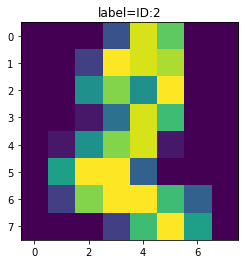



Michine misjudged 5 as 9


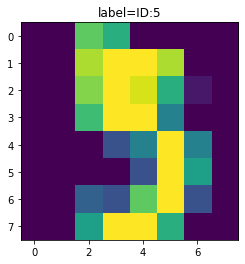

In [ ]:
#0から9の番号を与え、機械と人間が数字を何と判断したか可視化する

for i in range(0,10):
  x_id = x[i].reshape(8,8)
  #正解ラベル
  y_correct = y_raw[i]
  y_predict = y_pred[i]

  if y_correct != y_predict:
    print("Michine misjudged {} as {}".format(y_correct,y_predict))
    plt.imshow(x_id)
    plt.title("label=ID:"+str(i))
    plt.show()
    print("\n")

## 結果
上より、単層のニューラルネットワークでは正答率は75%しか出ないことがわかった。その理由は単層では線形分離にしかならず、64個の特徴量を用いた分類は線形分離では分類できないことがわかる。それもしくは、digits画像の解像度が低いことがあげられる。ではどうすればいいのかというと、カーネル関数にガウシアンカーネルを用いたサポートベクトルマシンを分類器として使うか、多層のニューラルネットワークを用いる方法があげられる。scikit-learnのSVCを用いればサポートベクトルマシンは簡単に実装可能であり、全結合ニューラルネットワークもkerasやpytorchを用いれば簡単に実装できる。今回は勉強としてnumpyを用いて1からコードを書く練習をしたかったため単層ニューラルネットワークを実装した。では多層ニューラルネットワークも実装すればよいではないかと言われるかもしれないが、全部自分で実装はとても大変である。（一回本を読みながら実装したがとても大変で複雑になった）

## チャレンジ
最後にライブラリーを頼りながら実践機械学習2でやると思われる多層のニューラルネットワークを実装してみる

使用ライブラリー \
Pytorch 参照:https://pytorch.org/

ネットワークの構築 \
64個の特徴量データ→ 32個のニューロンをもつ隠れ層1→  16個のニューロンを持つ隠れ層→ 10クラスの出力データ

In [ ]:
import torch 
from torch import nn,optim

#多層ニューラルネットワークのクラスを生成
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.ReLU = nn.ReLU()
    self.Linear1 = nn.Linear(64,32)
    self.Linear2 = nn.Linear(32,16)
    self.Linear3 = nn.Linear(16,10)
  
  def forward(self,x):
    x = self.Linear1(x)
    x = self.ReLU(x)
    x = self.Linear2(x)
    x = self.ReLU(x)
    x = self.Linear3(x)
    return x 

In [ ]:
#データセットの読み込み
from sklearn import datasets
digits = datasets.load_digits()

x = digits.data
y = digits.target 

x = torch.tensor(x,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.int64)

In [ ]:
net = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

#正答率と損失関数を格納する配列を設ける
#損失値を格納する配列
loss_value = []
#正答率を格納する配列
acc_value = []

EPOCH = 100
for epoch in range(EPOCH):
  #前回のループで計算された勾配の初期化
  optimizer.zero_grad()
  #予想値を計算
  y_pred = net(x)

  #交差エントロピーを用いて損失関数を計算
  loss = loss_fn(y_pred,y)
  #自動微分により勾配を計算
  loss.backward()

  #パラメーターの更新
  optimizer.step()

  #one hot 配列からy_rawと同じ型に変換する
  _ , y_pred = torch.max(y_pred,1)

  #正答率を計算
  acc = (y_pred == y).sum() / len(y)

  loss_value.append(loss.item())
  acc_value.append(acc)

  print("EPOCH: {} Accuracy: {}".format(epoch,acc))

EPOCH: 0 Accuracy: 0.1519198715686798
EPOCH: 1 Accuracy: 0.16861435770988464
EPOCH: 2 Accuracy: 0.1775180846452713
EPOCH: 3 Accuracy: 0.18363939225673676
EPOCH: 4 Accuracy: 0.18475235998630524
EPOCH: 5 Accuracy: 0.18530884385108948
EPOCH: 6 Accuracy: 0.18586532771587372
EPOCH: 7 Accuracy: 0.18809126317501068
EPOCH: 8 Accuracy: 0.18864774703979492
EPOCH: 9 Accuracy: 0.19143016636371613
EPOCH: 10 Accuracy: 0.1964385062456131
EPOCH: 11 Accuracy: 0.2020033448934555
EPOCH: 12 Accuracy: 0.21313299238681793
EPOCH: 13 Accuracy: 0.22871452569961548
EPOCH: 14 Accuracy: 0.2437395602464676
EPOCH: 15 Accuracy: 0.25264328718185425
EPOCH: 16 Accuracy: 0.2643294334411621
EPOCH: 17 Accuracy: 0.2776850163936615
EPOCH: 18 Accuracy: 0.2860322892665863
EPOCH: 19 Accuracy: 0.2943795323371887
EPOCH: 20 Accuracy: 0.3005008399486542
EPOCH: 21 Accuracy: 0.3132999539375305
EPOCH: 22 Accuracy: 0.31496939063072205
EPOCH: 23 Accuracy: 0.3249861001968384
EPOCH: 24 Accuracy: 0.33834168314933777
EPOCH: 25 Accuracy: 0.

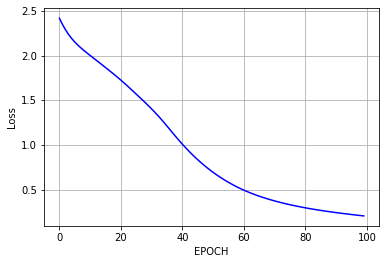

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(loss_value,color="blue",label="loss")
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

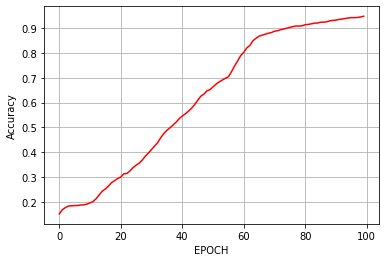

In [ ]:
plt.plot(acc_value,color="red",label="accuracy")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Digitsデータの可視化プログラム

上で可視化した手書き数字は、改造度が低いため、大きく表示してもその数字がなんだかわからない。したがって、各数字を小さく可視化して、色も変えてみるとうまく見えるようになるかもしれない。具体的には、`matplotlib.pyplot.imshow`には、`cmap`という引数が用意されており、これで色を変えることができる。今回は、白黒で表示させたいので、`cmap=matplotlib.cm.binary`と指定する。更に、各数字が識別可能か見るために、各数字10個の軽100個を格子状に並べる。

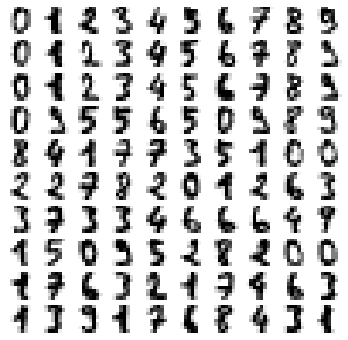

In [ ]:
import matplotlib

plt.figure(figsize=(6, 6))
for i in range(100): 
  plt.subplot(10, 10, i+1)
  plt.imshow(x[i].reshape(8, 8),interpolation='nearest', cmap=matplotlib.cm.binary)
  plt.axis('off')
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1525, in _init_draw
    artist.set_visible(False)
AttributeError: 'numpy.ndarray' object has no attribute 'set_visible'


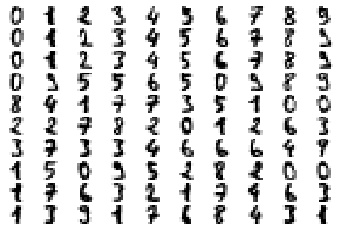

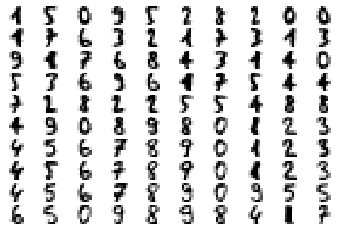

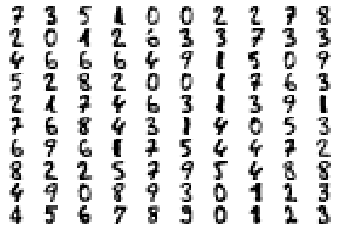

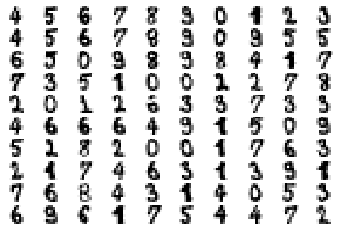

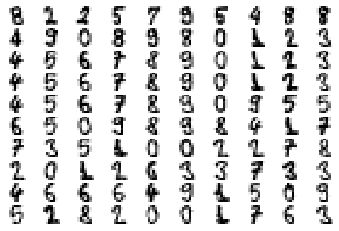

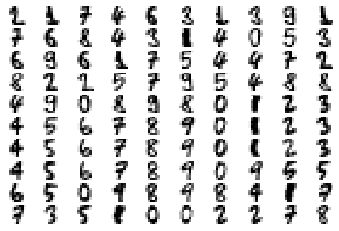

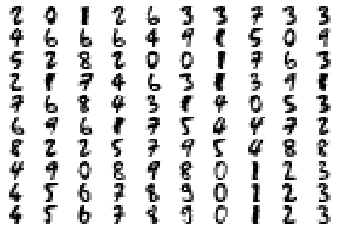

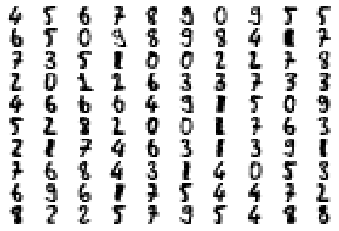

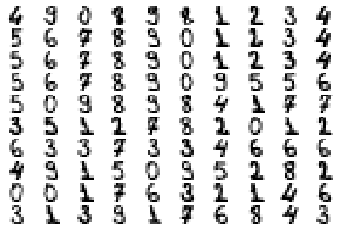

In [ ]:
from matplotlib.animation import ArtistAnimation
frames = []
for i in range(10): 
  fig, axes = plt.subplots(10, 10)
  for row, ax in enumerate(axes): 
    for col in range(0, 10): 
      ax[col].imshow(x[10*row + col + 100*i].reshape(8, 8), interpolation='nearest', cmap=matplotlib.cm.binary)
      ax[col].axis('off')
  frames.append(axes)
anim = ArtistAnimation(fig, frames, interval=1000)
fig.show()